In [1]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u



plt.rcParams['pdf.fonttype']=42
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [74]:
# load session
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
mouse = 'SparseKO_02'
d = sparse_sessions[mouse][4]
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']



pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls/', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)


In [75]:
trial_masks = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}
# channel_0_mask = sess.trial_info['block_number']%2==0
left_mask = sess.trial_info['LR']==-1
print(sess.trial_info['LR'],left_mask)


# trial_masks['channel_0_left'] = channel_0_mask*left_mask
# trial_masks['channel_0_right'] = channel_0_mask*(~left_mask)
# trial_masks['channel_1_left'] = (~channel_0_mask)*left_mask
# trial_masks['channel_1_right'] = (~channel_0_mask)*(~left_mask)

trial_masks['channel_0_left'] = left_mask
trial_masks['channel_0_right'] = (~left_mask)
trial_masks['channel_1_left'] = left_mask
trial_masks['channel_1_right'] = (~left_mask)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1.
  1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1.
 -1.] [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False  True False False  True False False Fa

In [52]:
# pc mask

chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']

chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right

F = sess.timeseries['channel_1_spks']
F_chan1_mask = F[chan1_mask] 

F = sess.timeseries['channel_0_spks']
F_chan0_mask = F[chan0_mask]

In [8]:
def run_shuffle(F, trial_starts, teleports, t, rng):
    
    F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*F[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        F_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(F_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    return np.nanmean(tmat,axis=0)




In [53]:
# shuffle pc only 

rng = np.random.default_rng()

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}


F = F_chan0_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan0_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


F = F_chan1_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan1_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


In [5]:
# all cells

rng = np.random.default_rng()
nperms = 1000

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}

F = sess.timeseries['channel_0_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)

F = sess.timeseries['channel_0_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)


F = sess.timeseries['channel_1_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)

F = sess.timeseries['channel_1_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)




(1000, 30, 331)
(1000, 30, 331)
(1000, 30, 234)
(1000, 30, 234)


In [35]:
# pc only 

trial_means = {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_left'], : , :][...,chan0_mask_pf_left]),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_right'], : , :][...,chan0_mask_pf_right]),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_left'], : , :][...,chan1_mask_pf_left]),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_right'], : , :][...,chan1_mask_pf_right]),
              }

IndexError: boolean index did not match indexed array along dimension 2; dimension is 270 but corresponding boolean dimension is 318

In [36]:
# all cells

trial_means = {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_right'], : , :], axis=0),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_right'], : , :],axis=0),
              }

In [54]:

shuff_results[mouse][5] = shuff_thresh

In [25]:
sess.novel_arm

-1

In [28]:
shuff_results[1]

KeyError: 1

In [16]:
sess.trial_info['LR']

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,
       -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,
        1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.])

In [158]:
# def make_masks(sess):
#     trial_masks = {'channel_0_left': None,
#                'channel_0_right': None,
#                'channel_1_left': None,
#                'channel_1_right': None}

#     left_mask = sess.trial_info['LR']==-1
#     # print(sess.trial_info['LR'],left_mask)
    
#     trial_masks['channel_0_left'] = left_mask
#     trial_masks['channel_0_right'] = (~left_mask)
#     trial_masks['channel_1_left'] = left_mask
#     trial_masks['channel_1_right'] = (~left_mask)


#     chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
#     chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
#     chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
#     chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']
    
#     chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
#     chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right
    
#     F1 = sess.timeseries['channel_1_spks']
#     F_chan1_mask = F1[chan1_mask] 
    
#     F0 = sess.timeseries['channel_0_spks']
#     F_chan0_mask = F0[chan0_mask]

#     return trial_masks

In [165]:
def make_masks(sess):
    trial_masks = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}
    left_mask = sess.trial_info['LR']==-1
    
    trial_masks['channel_0_left'] = left_mask
    trial_masks['channel_0_right'] = ~left_mask
    trial_masks['channel_1_left'] = left_mask
    trial_masks['channel_1_right'] = ~left_mask

    return trial_masks

In [124]:
np.where(chan0_mask)[0].shape
chan0_mask.shape

(270,)

In [28]:
# trial_means['SparseKO_02'][4]= {'channel_0_nov_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_left'], : , :],axis=0),
#                'channel_0_fam_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_right'], : , :], axis=0),
#                'channel_1_nov_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_left'], : , :],axis=0),
#                'channel_1_fam_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_right'], : , :],axis=0),
#               }
for day in range(6):
    trial_means['SparseKO_03'][day]= {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['channel_0_left'], : , :][...,chan0_mask_pf_left]),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['channel_0_right'], : , :][...,chan0_mask_pf_right]),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_F_dff'][trial_masks['channel_1_left'], : , :][...,chan1_mask_pf_left]),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_F_dff'][trial_masks['channel_1_right'], : , :][...,chan1_mask_pf_right]),
              }

In [166]:
def get_field_info(shuff_thresh, trial_means):
    field_info = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}

    for k, thresh in shuff_thresh.items():
        
        sig_bins = trial_means[k]>thresh
    
        # eliminate fields that start at first bin of track or end at last bin of track
        
    
        ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
        
        for _ledge in ledges:
    
            rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
            _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
            # print(_redge.size)
            if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0):
                field_info[k].append([_ledge[1], _ledge[0], _redge[0][0]])
    
    
    for k,v in field_info.items():
        field_info[k]=np.array(v)

    return field_info

In [183]:
sparse_mice[1:3]

('SparseKO_02', 'SparseKO_03')

In [186]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice
# shuff_results = {}
# trial_means = {}
# field_info = {}

for mouse in sparse_mice[1:2]:
    print(mouse)
    # shuff_results[mouse] = {}
    trial_means[mouse] = {}
    field_info[mouse] = {}
    for day in range(6):

        # set up output dicts
        # shuff_results[mouse][day] = {}
        trial_means[mouse][day] = {}
        field_info[mouse][day] = {}

        # load sess file
        sess = u.load_single_day(mouse, day)

        # make LR masks
        trial_masks = make_masks(sess)


        # rng = np.random.default_rng()

        # shuff_thresh = {'channel_0_left': None,
        #                'channel_0_right': None,
        #                'channel_1_left': None,
        #                'channel_1_right': None}
        
        # F1 = F_chan0_mask
        # starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
        # shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F1, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        # shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        # F2 = F_chan0_mask
        # starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
        # shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F2, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        # shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        # F3 = F_chan1_mask
        # starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
        # shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F3, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        # shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        # F4 = F_chan1_mask
        # starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
        # shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F4, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        # shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


        # run shuffle 
        rng = np.random.default_rng()

        shuff_thresh = {'channel_0_left': None,
                       'channel_0_right': None,
                       'channel_1_left': None,
                       'channel_1_right': None}
        
        F1 = sess.timeseries['channel_0_spks']
        starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F1, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F2 = sess.timeseries['channel_0_spks']
        starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F2, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        F3 = sess.timeseries['channel_1_spks']
        starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F3, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F4 = sess.timeseries['channel_1_spks']
        starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F4, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        # caluculate trial means
        temp_trial_means= {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_right'], : , :],axis=0),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_right'], : , :],axis=0),
              }
        
        
        shuff_thresh = shuff_results[mouse][day]
        temp_field_info = get_field_info(shuff_thresh, temp_trial_means)

        # shuff_results[mouse][day] = shuff_thresh # save to shuff_results
        trial_means[mouse][day] = temp_trial_means # save to trial_means
        field_info[mouse][day] = temp_field_info #save to field info
        


SparseKO_02
{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}


In [203]:
import pickle 
with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_results.pkl','wb') as file:
        pickle.dump(shuff_results,file)

In [204]:
with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_trial_means.pkl','wb') as file:
        pickle.dump(trial_means,file)

In [205]:
with open('C://Users/esay/data/Stx3/YMazeSessPkls/field_info.pkl','wb') as file:
        pickle.dump(field_info,file)

In [193]:
field_info['SparseKO_05'][1].keys()

dict_keys(['channel_0_left', 'channel_0_right', 'channel_1_left', 'channel_1_right'])

In [189]:
shuff_results['SparseKO_03'][5]['channel_1_right'].shape

(30, 18)

In [190]:
trial_means['SparseKO_03'][5]['channel_1_right'].shape

(30, 18)

In [200]:
field_info[mouse][day].keys()

dict_keys(['channel_0_left', 'channel_0_right', 'channel_1_left', 'channel_1_right'])

In [213]:
df = {'mouse': [],
      'cond':[],
      'ttype':[],
      'day':[],
      'field_width':[],
      'n_fields':[]}

for mouse in sparse_mice:
    for day in range(6):
        for key in field_info[mouse][day].keys():
            df['mouse'].append(mouse)
            df['day'].append(day)

            if 'channel_0' in key:
                df['cond'].append('cre') # seperate channel0 from left and right
            elif 'channel_1' in key:
                df['cond'].append('ctrl')

            if mouse == "SparseKO_02" or "SparseKO_05":
                if 'left' in key:
                    df['ttype'].append('nov')
                elif 'right' in key:
                    df['ttype'].append('fam')
            elif mouse == "SparseKO_03":
                if 'left' in key:
                    df['ttype'].append('fam')
                elif 'right' in key:
                    df['ttype'].append('nov')

            f_info = np.array(field_info[mouse][day][key])

            if f_info.size > 0:
                df['field_width'].append(f_info[:,2].mean())
                cell_list = np.unique(f_info[:,0])
                df['n_fields'].append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).mean())
            else:
                df['field_width'].append(np.nan)
                df['n_fields'].append(0)

            
df = pd.DataFrame(df)


In [214]:
df

,mouse,cond,ttype,day,field_width,n_fields
0,SparseKO_05,cre,nov,0,5.111437,1.397541
1,SparseKO_05,cre,fam,0,5.158537,1.281250
2,SparseKO_05,ctrl,nov,0,4.837500,1.176471
3,SparseKO_05,ctrl,fam,0,6.000000,1.176471
4,SparseKO_05,cre,nov,1,4.868914,1.271429
...,...,...,...,...,...,...
67,SparseKO_03,ctrl,fam,4,5.166667,1.200000
68,SparseKO_03,cre,nov,5,4.822222,1.168831
69,SparseKO_03,cre,fam,5,5.029412,1.416667
70,SparseKO_03,ctrl,nov,5,5.411765,1.307692


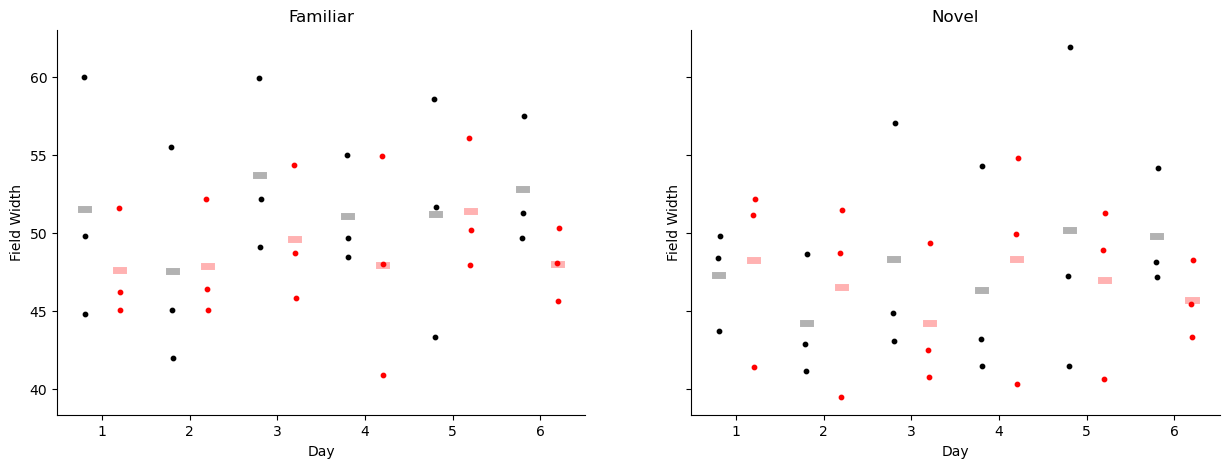

In [216]:
lw = 5
s = 10
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')

figdir = "C://Users/esay/data/Stx3/fig_scratch/behavior"
fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary.pdf"))

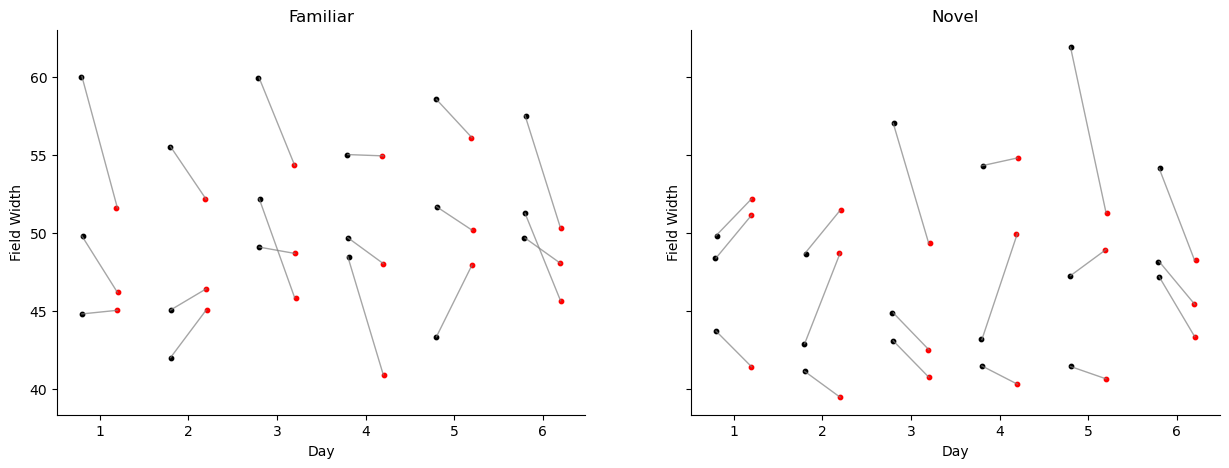

In [223]:
lw = 5
s = 10
fig, ax = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
# Iterate through days
for day in range(6):
    # Plot ctrl fam (black) and cre fam (red) in Familiar
    mask_ctrl_fam = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'fam')
    mask_cre_fam = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'fam')
    # Extract mouse names and field widths
    ctrl_fam = df.loc[mask_ctrl_fam, ['mouse', 'field_width']].reset_index(drop=True)
    cre_fam = df.loc[mask_cre_fam, ['mouse', 'field_width']].reset_index(drop=True)
    # Plot black and red dots
    ax[0].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_fam)), 10*ctrl_fam['field_width'], color='black', s=s)
    ax[0].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_fam)), 10*cre_fam['field_width'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_fam['mouse']:
        if mouse in cre_fam['mouse'].values:
            y1 = 10 * ctrl_fam.loc[ctrl_fam['mouse'] == mouse, 'field_width'].values[0]
            y2 = 10 * cre_fam.loc[cre_fam['mouse'] == mouse, 'field_width'].values[0]
            ax[0].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
    # Plot ctrl nov (black) and cre nov (red) in Novel
    mask_ctrl_nov = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'nov')
    mask_cre_nov = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'nov')
    ctrl_nov = df.loc[mask_ctrl_nov, ['mouse', 'field_width']].reset_index(drop=True)
    cre_nov = df.loc[mask_cre_nov, ['mouse', 'field_width']].reset_index(drop=True)
    ax[1].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_nov)), 10*ctrl_nov['field_width'], color='black', s=s)
    ax[1].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_nov)), 10*cre_nov['field_width'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_nov['mouse']:
        if mouse in cre_nov['mouse'].values:
            y1 = 10 * ctrl_nov.loc[ctrl_nov['mouse'] == mouse, 'field_width'].values[0]
            y2 = 10 * cre_nov.loc[cre_nov['mouse'] == mouse, 'field_width'].values[0]
            ax[1].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
# Set titles and labels
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
for a in range(2):
    ax[a].set_xticks(np.arange(0, 6*5, 5))
    ax[a].set_xticklabels([x for x in range(1, 7)])
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')
# Save figure
figdir = "C://Users/esay/data/Stx3/fig_scratch/behavior"
fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary_with_lines.pdf"))
plt.show()

Text(0.5, 0, 'Day')

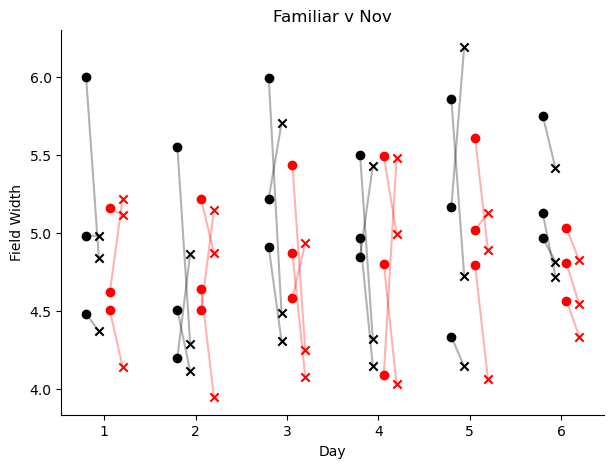

In [222]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in sparse_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in sparse_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Field Width')
ax.set_xlabel('Day')

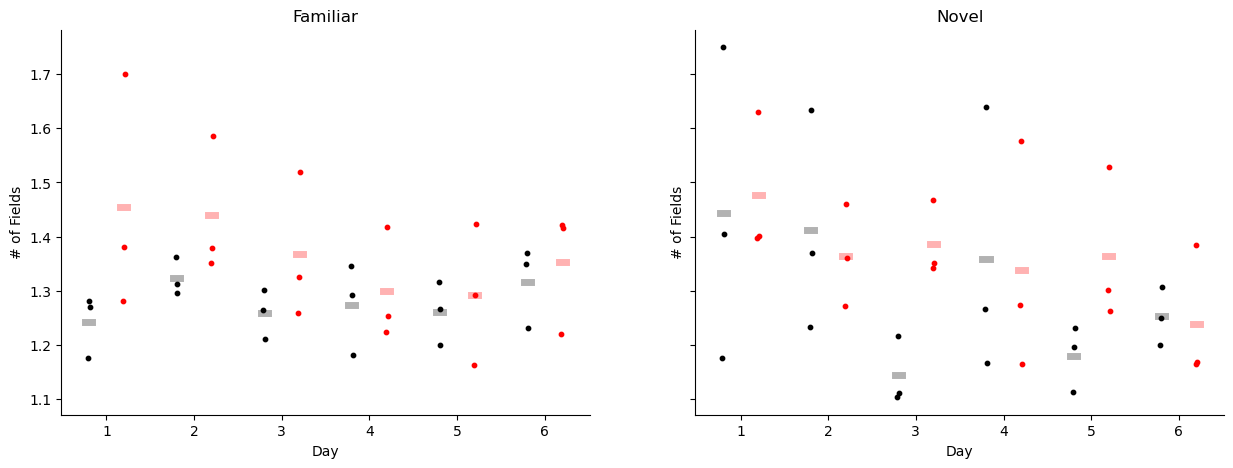

In [217]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('# of Fields')
    ax[a].set_xlabel('Day')
fig.savefig(os.path.join(figdir, "num_fields_across_mouse_summary.pdf"))


In [98]:
for mouse, days in trial_means.items():
    for day, metrics in days.items():
        for key in list(metrics.keys()):
            if "nov_mean" in key:
                metrics[key.replace("nov_mean","left")] = metrics.pop(key)
            elif "fam_mean" in key:
                metrics[key.replace("fam_mean","right")] = metrics.pop(key)

(array([0.55223881, 0.32835821, 0.11940299, 0.        ]),
 array([1., 2., 3., 4., 5.]),
 <BarContainer object of 4 artists>)

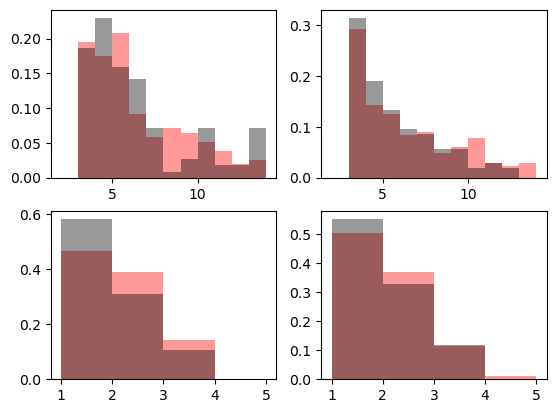

In [10]:
fig, ax = plt.subplots(2,2)

width_bins = np.arange(2,15)
field_bins = np.arange(1,6)
##
fi = field_info['channel_0_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)

##
fi = field_info['channel_1_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)

##
fi = field_info['channel_0_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)


##
fi = field_info['channel_1_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)


    